In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import mglearn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import colors as mcolors
from sklearn.decomposition import PCA
import sklearn
import matplotlib.patches as mpatches
import statsmodels.discrete.discrete_model as sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

 # Load Data and Create Tables

In [2]:
weeks = {0:"Monday", 1:"Tuesday", 2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"}

In [3]:
driver_id = pd.read_csv('data/driver_ids.csv')
ride_id = pd.read_csv('data/ride_ids.csv')
ride_time = pd.read_csv('data/ride_timestamps.csv')

driver_id["driver_onboard_date"] = pd.to_datetime(driver_id["driver_onboard_date"])
ride_time["timestamp"] = pd.to_datetime(ride_time["timestamp"])

Create a table that summarizes each ride
Calculate a total travel time, total travel that a driver needed to pick up the customer, and a time that the driver needed to accept the request

In [4]:
pivoted_ride_time = ride_time.pivot(index='ride_id',columns='event',values='timestamp').reset_index()
summary = pd.merge(pivoted_ride_time, ride_id[["ride_id","driver_id"]], on = 'ride_id')

summary["total_travel_time"] = (summary["dropped_off_at"] - summary["accepted_at"]).dt.total_seconds()
summary["travel_pick_up"] = (summary["arrived_at"] - summary["accepted_at"]).dt.total_seconds()
summary["request_accepted_time"]= (summary["arrived_at"] - summary["accepted_at"]).dt.total_seconds()

Since the fares are given in minutes and miles, change units from seconds to minutes and meters to miles

In [5]:
ride_id["ride_duration"]=ride_id["ride_duration"]/60
ride_id["ride_distance"]=ride_id["ride_distance"]/1609.344

Calculate Fares and Total Fares after applying Prime Time
<br>
Assumed commission of 25%.


In [6]:
ride_id["fare"]=1.75 + 2.0 + 1.15*ride_id["ride_distance"] + 0.22*ride_id["ride_duration"]
ride_id["fare"][ride_id["fare"]<5] = 5
ride_id["total_fare"] = ride_id["fare"]+ride_id["fare"]*ride_id["ride_prime_time"]/100
ride_id["commission"] = ride_id["total_fare"]*0.25

# Ignore the warning

/Users/hoang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
print("The number of unique rides in the pivoted table ride_time is "+str(len(summary["ride_id"].unique())))
print("The number of unique rides in the table ride_id is "+str(len(ride_id["ride_id"].unique())))

The number of unique rides in the pivoted table ride_time is 184819
The number of unique rides in the table ride_id is 193502


Need to analyse the missing Data. Hopefully looking at the numbers they don't seem to have any pattern. Assume missing data at random. Exclude the observations from analysis

In [8]:
ride_id.loc[(~ride_id.ride_id.isin(summary["ride_id"]))].head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,fare,total_fare,commission
3687,056175954c78be4c4de7e80167b7e1f9,0488679087be6f76612dfc9ecba227e5,1.285617,6.783333,0,6.720793,6.720793,1.680198
3688,056175954c78be4c4de7e80167b7e1f9,060d6b3e4916e1aec8cc1e746f6fd87e,1.048875,6.150000,0,6.309206,6.309206,1.577301
3689,056175954c78be4c4de7e80167b7e1f9,075f23b3edafd5020837b14b79d7b9e8,8.010096,21.933333,0,17.786944,17.786944,4.446736
3690,056175954c78be4c4de7e80167b7e1f9,0d4727f995ee19c0ed4654b0a5a82176,1.282510,7.216667,0,6.812553,6.812553,1.703138
3691,056175954c78be4c4de7e80167b7e1f9,0f1f969a4ddc30c8c9c14509156e3149,2.491698,15.733333,0,10.076787,10.076787,2.519197


In [9]:
print("The number of missing drivers from the analysis "+str(len((ride_id.loc[(~ride_id.ride_id.isin(summary["ride_id"]))]["driver_id"]).unique())))

The number of missing drivers from the analysis 93


Merge tables to obtain a ride_id table without missing values

In [10]:
summary.head()

,ride_id,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at,driver_id,total_travel_time,travel_pick_up,request_accepted_time
0,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 10:03:05,2016-06-13 09:44:33,2016-06-13 09:39:19,d967f5296732fa55266b5f1314e7447b,1394.0,280.0,280.0
1,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:34:17,2016-05-14 05:26:18,2016-05-14 05:23:21,0656192a402808805282e60761bda088,652.0,172.0,172.0
2,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:54:18,2016-05-16 15:47:32,2016-05-16 15:43:09,c468a648519cd42da75e6aa9dadf733e,664.0,255.0,255.0
3,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:40:47,2016-05-11 19:35:15,2016-05-11 19:29:36,689bdf87fb2de49f98bf4946cfaa5068,664.0,328.0,328.0
4,00012759befd5d34a0609800f6a1ee59,2016-05-31 15:45:05,2016-05-31 15:46:22,2016-05-31 15:59:26,2016-05-31 15:46:23,2016-05-31 15:44:56,eece82fe623b4bb335a9b9e20eb0ca54,861.0,77.0,77.0


In [11]:
ride_id = pd.merge(ride_id,summary[["ride_id","request_accepted_time","travel_pick_up","total_travel_time"]], on ="ride_id")

In [12]:
print("Available Data for "+str(summary["accepted_at"].max()-summary["accepted_at"].min()))
print("First date: "+str(summary["accepted_at"].min()))
print("Last date :"+str(summary["accepted_at"].max()))

Available Data for 90 days 18:09:26
First date: 2016-03-28 05:48:23
Last date :2016-06-26 23:57:49


In [13]:
# see if any missing values
pd.isnull(ride_id).any(1).nonzero()[0]

array([97152])

In [14]:
ride_id.iloc[97152]
#drop missing data

driver_id                7c1478b12207107ae4296e656a49d6f6
ride_id                  72f0fa0bd86800e9da5c4dced32c8735
ride_distance                                     2.75267
ride_duration                                     14.1667
ride_prime_time                                        75
fare                                              10.0322
total_fare                                        17.5564
commission                                        4.38911
request_accepted_time                                 NaN
travel_pick_up                                        NaN
total_travel_time                                    1150
Name: 97152, dtype: object

In [15]:
ride_id = ride_id.dropna()

Convert other newly addded time variables 

In [16]:
ride_id["request_accepted_time"]=ride_id["request_accepted_time"]/60
ride_id["travel_pick_up"]=ride_id["travel_pick_up"]/60
ride_id["total_travel_time"]=ride_id["total_travel_time"]/60

# Analysis 1 : Cleaning Data
Remove outliers and unplausible observations
<br>
First Let see the data before cleaning

In [17]:
ride_id.describe()

,ride_distance,ride_duration,ride_prime_time,fare,total_fare,commission,request_accepted_time,travel_pick_up,total_travel_time
count,184818.000000,184818.000000,184818.000000,184818.000000,184818.000000,184818.000000,184818.000000,184818.000000,184818.000000
mean,4.313246,14.328303,17.383453,11.868172,13.844602,3.461150,4.097520,4.097520,18.514620
std,5.550018,9.542362,30.842173,8.138380,10.114017,2.528504,3.620746,3.620746,10.622422
min,-0.001243,0.033333,0.000000,5.000000,5.000000,1.250000,0.050000,0.050000,0.116667
25%,1.526088,8.200000,0.000000,7.420501,8.161175,2.040294,2.083333,2.083333,11.733333
50%,2.488592,12.116667,0.000000,9.412160,10.839354,2.709839,3.333333,3.333333,16.200000
75%,4.452746,17.833333,25.000000,12.835484,15.626836,3.906709,5.200000,5.200000,22.450000
max,450.294654,470.066667,500.000000,625.003519,625.003519,156.250880,699.433333,699.433333,699.966667


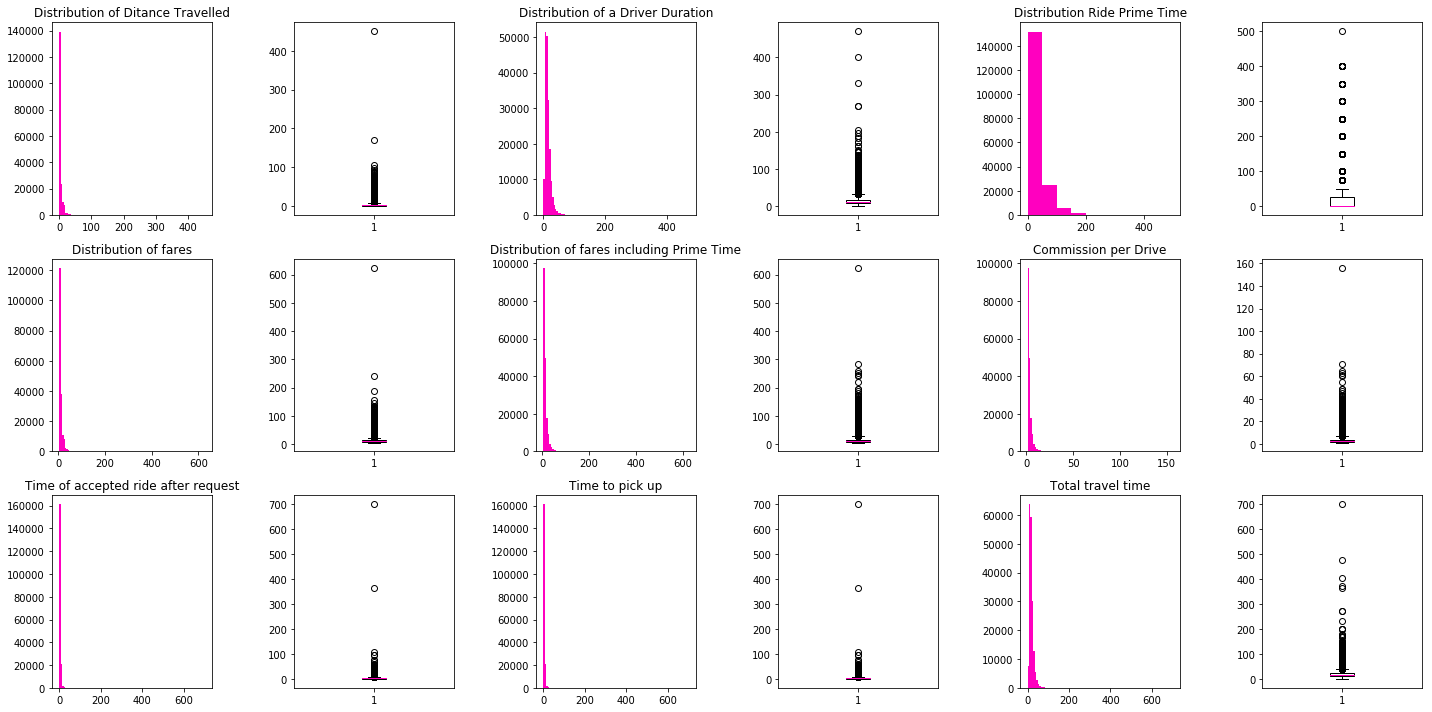

In [18]:
f, ((ax11, ax12,ax13,ax14,ax15,ax16),(ax21,ax22,ax23,ax24,ax25,ax26),(ax31,ax32,ax33,ax34,ax35,ax36)) = plt.subplots(3,6,figsize =(20,10))
###################################################
ax11.set_title('Distribution of Ditance Travelled')
ax11.hist(ride_id['ride_distance'],bins=100, color=["#ff00bf"])
ax12.boxplot(ride_id['ride_distance'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))

ax13.set_title('Distribution of a Driver Duration')
ax13.hist(ride_id['ride_duration'],bins=100, color=["#ff00bf"])
ax14.boxplot(ride_id['ride_duration'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))

ax15.set_title('Distribution Ride Prime Time')
ax15.hist(ride_id['ride_prime_time'], color=["#ff00bf"])
ax16.boxplot(ride_id['ride_prime_time'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))
###################################################
ax21.set_title('Distribution of fares')
ax21.hist(ride_id['fare'],bins=100, color=["#ff00bf"])
ax22.boxplot(ride_id['fare'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))

ax23.set_title('Distribution of fares including Prime Time')
ax23.hist(ride_id['total_fare'], bins=100, color=["#ff00bf"])
ax24.boxplot(ride_id['total_fare'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))

ax25.set_title('Commission per Drive')
ax25.hist(ride_id['commission'], bins=100, color="#ff00bf")
ax26.boxplot(ride_id['commission'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))
###################################################
ax31.set_title('Time of accepted ride after request')
ax31.hist(ride_id['request_accepted_time'],bins=100, color=["#ff00bf"])
ax32.boxplot(ride_id['request_accepted_time'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))

ax33.set_title('Time to pick up')
ax33.hist(ride_id['travel_pick_up'],bins=100, color=["#ff00bf"])
ax34.boxplot(ride_id['travel_pick_up'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))

ax35.set_title('Total travel time')
ax35.hist(ride_id['total_travel_time'],bins=100, color=["#ff00bf"])
ax36.boxplot(ride_id['total_travel_time'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))

plt.tight_layout()
plt.show()

#### After Cleaning
Remove the negative distance
<br>
keep values below 400, Lyft stated on the website the maximum fare of $400
<br>
Remove the distance above 150 miles. In 2014 the maximum distance was stated to be 100 miles. Assumption for 150 miles was made
<br>
Keep Rides below 300 minutes. There were single outliars of 300 and above 400 miles. They are not a good representation of the data sample

In [19]:
ride_id = ride_id.loc[ride_id['ride_distance']>0] 
ride_id = ride_id.loc[ride_id['fare']<100] 
ride_id = ride_id.loc[ride_id['ride_distance']<100]
ride_id = ride_id.loc[ride_id['ride_duration']<300] 
ride_id = ride_id.loc[ride_id['request_accepted_time']<300] 
ride_id = ride_id.loc[ride_id['travel_pick_up']<100] 
ride_id = ride_id.loc[ride_id['total_travel_time']<150] 

Let's look at the graphs after cleaning

In [20]:
ride_id.describe()

,ride_distance,ride_duration,ride_prime_time,fare,total_fare,commission,request_accepted_time,travel_pick_up,total_travel_time
count,184598.000000,184598.000000,184598.000000,184598.000000,184598.000000,184598.000000,184598.000000,184598.000000,184598.000000
mean,4.301699,14.310257,17.389950,11.850035,13.825281,3.456320,4.091438,4.091438,18.490991
std,5.356009,9.235298,30.849059,7.859545,9.850672,2.462668,3.117820,3.117820,10.175936
min,0.000621,0.033333,0.000000,5.000000,5.000000,1.250000,0.050000,0.050000,0.116667
25%,1.528573,8.200000,0.000000,7.425081,8.166260,2.041565,2.083333,2.083333,11.750000
50%,2.491077,12.133333,0.000000,9.415713,10.842745,2.710686,3.333333,3.333333,16.200000
75%,4.454610,17.833333,25.000000,12.837404,15.628528,3.907132,5.200000,5.200000,22.450000
max,67.909036,144.416667,500.000000,99.034960,257.009248,64.252312,97.800000,97.800000,147.666667


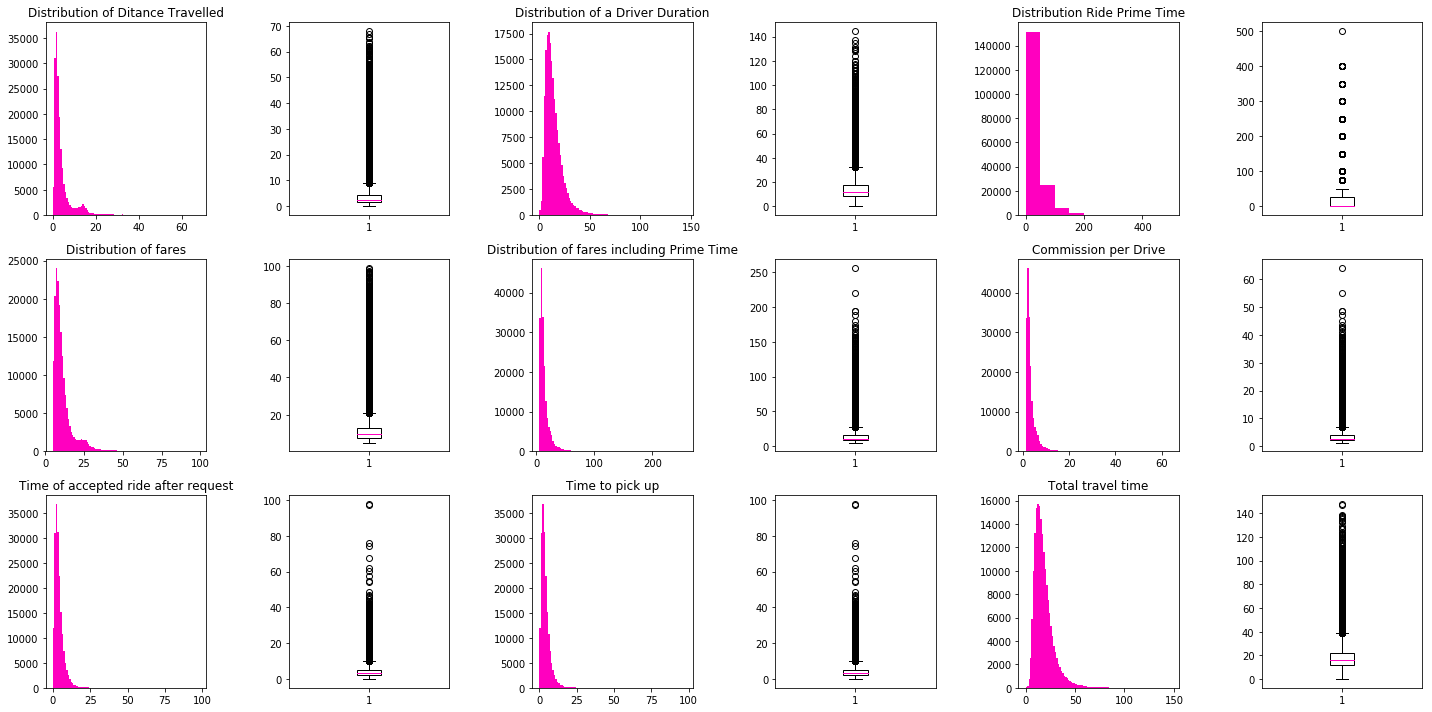

In [21]:
f, ((ax11, ax12,ax13,ax14,ax15,ax16),(ax21,ax22,ax23,ax24,ax25,ax26),(ax31,ax32,ax33,ax34,ax35,ax36)) = plt.subplots(3,6,figsize =(20,10))
###################################################
ax11.set_title('Distribution of Ditance Travelled')
ax11.hist(ride_id['ride_distance'],bins=100, color=["#ff00bf"])
ax12.boxplot(ride_id['ride_distance'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))

ax13.set_title('Distribution of a Driver Duration')
ax13.hist(ride_id['ride_duration'],bins=100, color=["#ff00bf"])
ax14.boxplot(ride_id['ride_duration'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))

ax15.set_title('Distribution Ride Prime Time')
ax15.hist(ride_id['ride_prime_time'], color=["#ff00bf"])
ax16.boxplot(ride_id['ride_prime_time'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))
###################################################
ax21.set_title('Distribution of fares')
ax21.hist(ride_id['fare'],bins=100, color=["#ff00bf"])
ax22.boxplot(ride_id['fare'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))

ax23.set_title('Distribution of fares including Prime Time')
ax23.hist(ride_id['total_fare'], bins=100, color=["#ff00bf"])
ax24.boxplot(ride_id['total_fare'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))

ax25.set_title('Commission per Drive')
ax25.hist(ride_id['commission'], bins=100, color="#ff00bf")
ax26.boxplot(ride_id['commission'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))
###################################################
ax31.set_title('Time of accepted ride after request')
ax31.hist(ride_id['request_accepted_time'],bins=100, color=["#ff00bf"])
ax32.boxplot(ride_id['request_accepted_time'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))

ax33.set_title('Time to pick up')
ax33.hist(ride_id['travel_pick_up'],bins=100, color=["#ff00bf"])
ax34.boxplot(ride_id['travel_pick_up'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))

ax35.set_title('Total travel time')
ax35.hist(ride_id['total_travel_time'],bins=100, color=["#ff00bf"])
ax36.boxplot(ride_id['total_travel_time'],patch_artist=True, boxprops=dict(facecolor="white", color="black"), medianprops=dict(color="#ff00bf"))

plt.tight_layout()
plt.show()

# Pre-Analysis of each Driver

To fully take the most of data, we need to create new variables and tables.
<br>
driver_total shows the total amount of commission, fare, driver distance
<br>
Since Prime Time increases the fare, for example Prime Time 500 increases the fare 5 times, a variables prime_minutes was created. It is the number of total minutes collected by Prime Time. Prime Time might be an interesting variable to investigate, because it gives us an idea, about the area and working hours of drivers.
<br>
Also variables for average distance, ride duration, Prime Time, fare, and fare including prime time during the drivers' life time were generated. Average and total values might have a different interpretations.
<br>
The number of total rides for each driver was also calculated.
<br>

In [22]:
ride_id["prime_minutes"]=ride_id['ride_prime_time']*(ride_id["ride_duration"]/100)

In [23]:
driver_total = ride_id.pivot_table(index='driver_id', values=('ride_distance','ride_duration','prime_minutes',"fare","total_fare", "commission"), aggfunc=np.sum).reset_index()


In [24]:
averages = ride_id.pivot_table(index='driver_id', values =('ride_distance', 'ride_duration', 'ride_prime_time','fare','total_fare'), aggfunc=np.average).rename(columns={'ride_distance':'average_ride_distance','ride_duration':'average_ride_duration','ride_prime_time':'average_ride_prime_time','fare':'average_fare','total_fare':'average_total_fare','travel_pick_up':'average_travel_pick_up'}).reset_index()
    

In [25]:
total_rides = ride_id.pivot_table(index="driver_id", values=("ride_id"),aggfunc="count").rename(columns={"ride_id":"no_rides"}).reset_index()

In [26]:
rider_id = pd.merge(ride_id[["driver_id","ride_id"]], ride_time, on = "ride_id")

In [27]:
ride_driver = rider_id.loc[rider_id["event"]=="accepted_at"]

Get a day of the last drive for each driver, it will be needed later to generate a churn rate.

In [28]:
last_drive = ride_driver.pivot_table(index='driver_id', values=('timestamp'),aggfunc=np.max).rename(columns={'timestamp':'last_time'}).reset_index()

In [29]:
ride_driver = rider_id.loc[rider_id["event"]=="accepted_at"]

Merge Tables.

In [30]:
driver_id = pd.merge(driver_id, driver_total, on = 'driver_id')
driver_id = pd.merge(driver_id, last_drive, on = 'driver_id')
driver_id = pd.merge(driver_id, total_rides, on = 'driver_id')
driver_id = pd.merge(driver_id, averages,on = 'driver_id')

Get the days of the week. Might be the case that drivers who drive on a certain days of the week, generate more income.

In [31]:
rider_id["weekday"] = rider_id["timestamp"].dt.dayofweek

In [32]:
driver_week = rider_id.pivot_table(index='driver_id', columns='weekday', values='ride_id', aggfunc="count",fill_value = 0).reset_index().rename(columns=weeks)


In [33]:

driver_id = pd.merge(driver_id, driver_week, on = 'driver_id')

Let's the numbers of total time that the driver needed to accepted each request, total travel time, total time that driver used to pick up a customer. Pick up time might be important.A long pick up time means, more money spent on gasoline and quicker car depreciation.

In [34]:
totals = summary.pivot_table(index="driver_id", values=('travel_pick_up','total_travel_time','arrived_at','request_accepted_time'),aggfunc=np.sum).reset_index()

In [35]:
# average prime time that a driver had during the given period being active
average_prime = ride_id.pivot_table(index="driver_id", values=('ride_prime_time','travel_pick_up','request_accepted_time'), aggfunc=np.average).reset_index().rename(columns={'travel_pick_up':'average_travel_pick_up','request_accepted_time':'average_request_accepted_time'})


driver_id = pd.merge(driver_id,totals, on = 'driver_id')
driver_id = pd.merge(driver_id,average_prime, on = 'driver_id')

We will further extract more variables.
<br>
The number of working days, number of rides per week, and the commission generated per week might have some predictive power.
<br>
It also would be interesting to see the ratio of how much driver spent on travelling to client on the total travel time(including the fare)

In [36]:
driver_id["worked_days"] = ((driver_id["last_time"]-driver_id["driver_onboard_date"]).dt.total_seconds())/(60*60*24)


In [37]:
driver_id['rides_per_week'] = driver_id["no_rides"]/((driver_id["last_time"]- driver_id["driver_onboard_date"]).dt.total_seconds()/(60*60*24*7))


driver_id["rides_per_week"].loc[driver_id["worked_days"]<7] = driver_id["no_rides"].loc[driver_id["worked_days"]<7]

/Users/hoang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [38]:
driver_id["commission_per_week"] = driver_id["commission"]/((driver_id["last_time"]- driver_id["driver_onboard_date"]).dt.total_seconds()/(60*60*24*7))

driver_id["commission_per_week"].loc[driver_id["worked_days"]<7] = driver_id["commission"].loc[driver_id["worked_days"]<7]

/Users/hoang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [39]:
driver_id["ratio_travel_client_total"]=driver_id["travel_pick_up"]/driver_id["total_travel_time"]

In [40]:
# given assumptions, how much income does a driver generates
driver_id["earning"]=driver_id["total_fare"]-1.15*driver_id["no_rides"]-driver_id["commission"]

In [41]:
# It might also be interesting to see how many prime minutes per day, did drivers have
driver_id["lifetime_prime_minutes"]=driver_id["prime_minutes"]/driver_id["worked_days"]

# Look into Data

driver_id is the final data used in the analysis

In [42]:
graph = driver_id[["lifetime_prime_minutes","earning","ratio_travel_client_total",'commission', 'fare','prime_minutes', 'ride_distance', 'ride_duration', 'total_fare', 'no_rides', 'average_fare', 'average_ride_distance','average_ride_duration', 'average_ride_prime_time','request_accepted_time','total_travel_time', 'travel_pick_up', 'average_request_accepted_time','ride_prime_time', 'average_travel_pick_up', 'rides_per_week','worked_days', 'commission_per_week']]

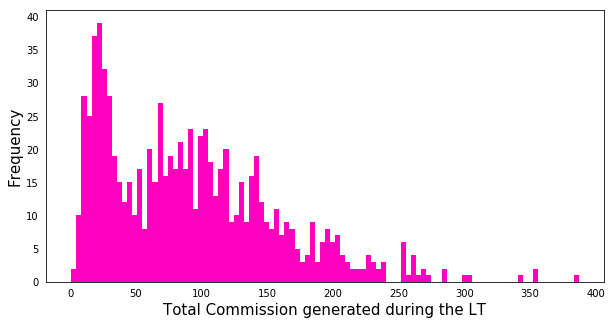

In [43]:
plt.figure(figsize=(10,5))
plt.hist(graph["commission_per_week"],bins=100, color=["#ff00bf"])
plt.xlabel("Total Commission generated during the LT", size = 15)
plt.ylabel("Frequency", size = 15)
plt.tick_params(axis='x',bottom=False)
plt.tick_params(axis='y',left=False)
plt.show()

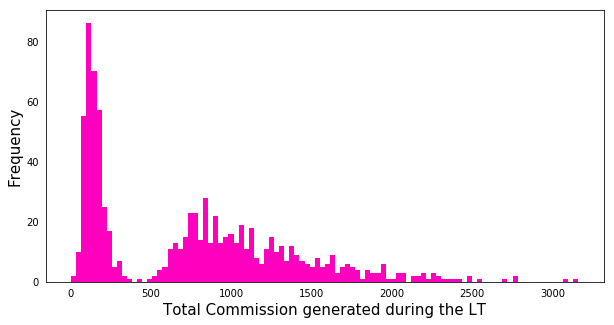

In [44]:
plt.figure(figsize=(10,5))
plt.hist(graph["commission"],bins=100, color=["#ff00bf"])
plt.xlabel("Total Commission generated during the LT", size = 15)
plt.ylabel("Frequency", size = 15)
plt.tick_params(axis='x',bottom=False)
plt.tick_params(axis='x',bottom=False)
plt.tick_params(axis='y',left=False)

plt.show()

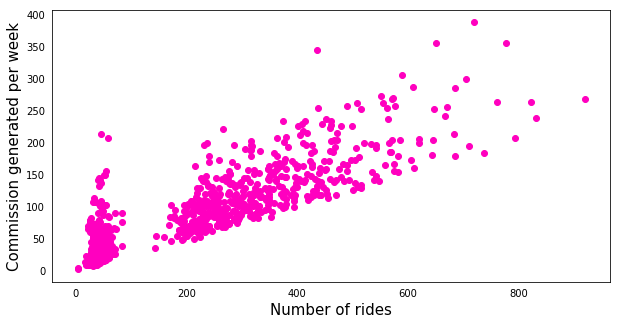

In [45]:
plt.figure(figsize=(10,5))
plt.scatter(graph["no_rides"],graph["commission_per_week"], color=["#ff00bf"])
plt.xlabel("Number of rides", size = 15)
plt.ylabel("Commission generated per week", size = 15)
plt.tick_params(axis='x',bottom=False)
plt.tick_params(axis='y',left=False)
plt.show()

The graphs shows an interesting shape. It seems that there might be two populations. Let's create a variable for churns and try to see if there are any patterns, when we add a new variable to the graphs. What if we add churn as the third variable?

# Churn

Since the variable for churns is not given, with some assumptions, we will create one.
For each driver, find his last ride. If a driver's last ride wasn't within the last 20 days, mark him as churned.
Also, we exclude from analysis drivers that joined in the last 20 days.

In [46]:
# Let's set the current date for a day after the most recent ride in data
today = driver_id["last_time"].max() + timedelta(days=1)
driver_id["churn"] = (today-driver_id["last_time"])>timedelta(days=20)
graph = driver_id[["churn","lifetime_prime_minutes","earning","ratio_travel_client_total",'commission', 'fare','prime_minutes', 'ride_distance', 'ride_duration', 'total_fare', 'no_rides', 'average_fare', 'average_ride_distance','average_ride_duration', 'average_ride_prime_time','request_accepted_time','total_travel_time', 'travel_pick_up', 'average_request_accepted_time','ride_prime_time', 'average_travel_pick_up', 'rides_per_week','worked_days', 'commission_per_week']]

In the next graphs, True is Churned, False is not Churned

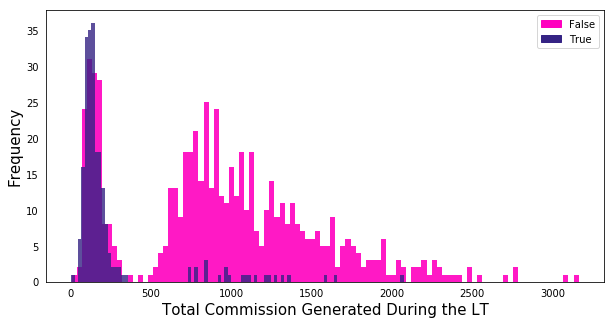

In [47]:
plt.figure(figsize=(10,5))
plt.hist((graph.loc[graph["churn"]==0])["commission"],bins=100,color="#ff00bf",alpha=0.9)
plt.hist((graph.loc[graph["churn"]==1])["commission"],bins=100,color="#352384",alpha=0.8)

plt.xlabel("Total Commission Generated During the LT", size = 15)
plt.ylabel("Frequency", size = 15)
patch0 = mpatches.Patch(color="#ff00bf", label='False')
patch1 = mpatches.Patch(color="#352384", label='True')

plt.legend(handles=[patch0, patch1])
plt.tick_params(axis='x',bottom=False)
plt.tick_params(axis='y',left=False)
plt.show()

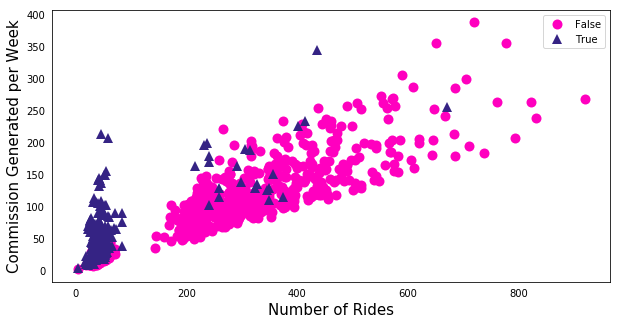

In [48]:
plt.figure(figsize=(10,5))
mglearn.discrete_scatter(graph["no_rides"].values, graph["commission_per_week"].values, graph["churn"].values, c = ["#ff00bf","#352384"], markeredgewidth=0)
plt.xlabel("Number of Rides", size = 15)
plt.ylabel("Commission Generated per Week", size = 15)
plt.legend()
plt.tick_params(axis='x',bottom=False)
plt.tick_params(axis='y',left=False)
plt.show()

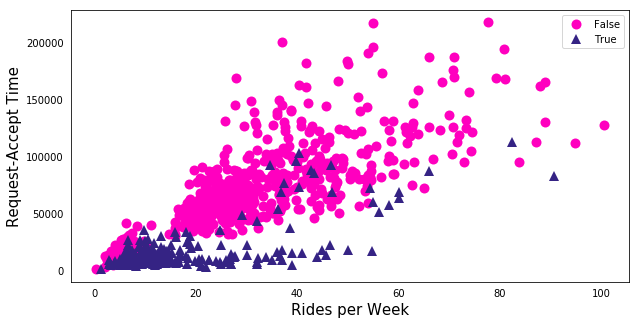

In [49]:
plt.figure(figsize=(10,5))
mglearn.discrete_scatter(graph["rides_per_week"].values, graph["request_accepted_time"].values, graph["churn"], c = ["#ff00bf","#352384"], markeredgewidth=0)
plt.xlabel("Rides per Week", size = 15)
plt.ylabel("Request-Accept Time", size = 15)
plt.legend()
plt.tick_params(axis='x',bottom=False)
plt.tick_params(axis='y',left=False)
plt.show()

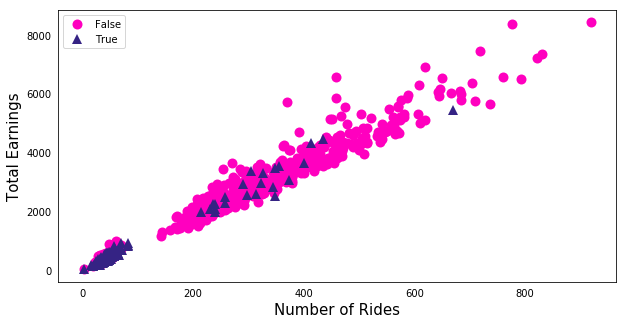

In [50]:
plt.figure(figsize=(10,5))
mglearn.discrete_scatter(graph["no_rides"].values, graph['earning'].values, graph["churn"], c = ["#ff00bf","#352384"], markeredgewidth=0)
plt.xlabel("Number of Rides", size = 15)
plt.ylabel("Total Earnings", size = 15)
plt.legend()
plt.tick_params(axis='x',bottom=False)
plt.tick_params(axis='y',left=False)
plt.show()

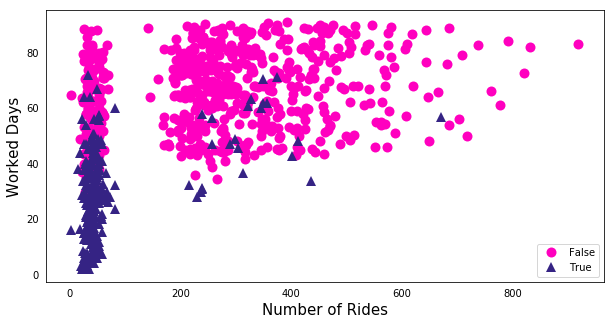

In [51]:
plt.figure(figsize=(10,5))
mglearn.discrete_scatter(graph["no_rides"].values, graph["worked_days"].values, graph["churn"], c = ["#ff00bf","#352384"], markeredgewidth=0)
plt.xlabel("Number of Rides", size = 15)
plt.ylabel("Worked Days", size = 15)
plt.legend()
plt.tick_params(axis='x',bottom=False)
plt.tick_params(axis='y',left=False)
plt.show()

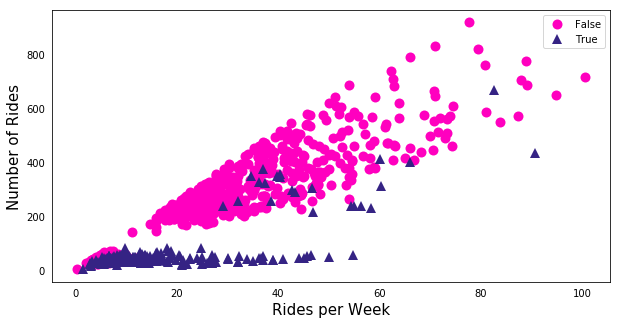

In [52]:
plt.figure(figsize=(10,5))
mglearn.discrete_scatter(graph["rides_per_week"].values, graph["no_rides"].values, graph["churn"], c = ["#ff00bf","#352384"], markeredgewidth=0)
plt.xlabel("Rides per Week", size = 15)
plt.ylabel("Number of Rides", size = 15)
plt.legend()
plt.tick_params(axis='x',bottom=False)
plt.tick_params(axis='y',left=False)
plt.show()

short term drivers

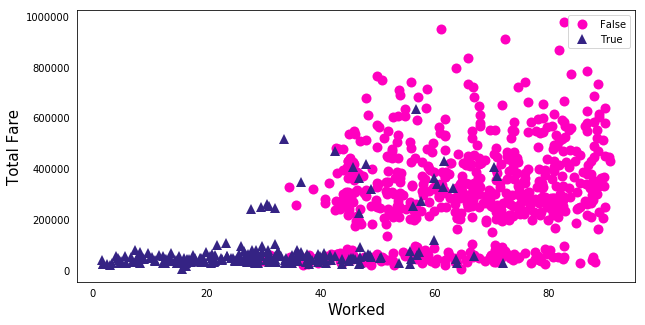

In [53]:
plt.figure(figsize=(10,5))
mglearn.discrete_scatter(graph["worked_days"].values, graph["total_travel_time"].values, graph["churn"], c = ["#ff00bf","#352384"], markeredgewidth=0)
plt.xlabel("Worked", size = 15)
plt.ylabel("Total Fare", size = 15)
plt.legend()
plt.tick_params(axis='x',bottom=False)
plt.tick_params(axis='y',left=False)
#plt.box(False)
plt.show()

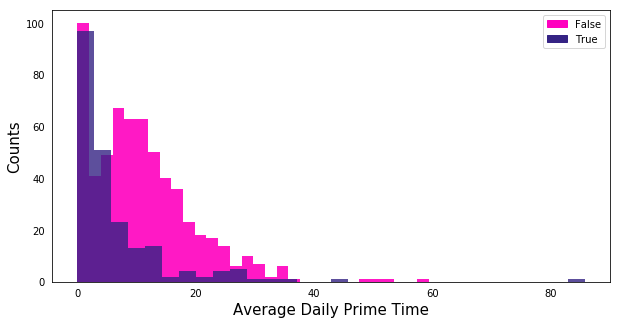

In [54]:
plt.figure(figsize=(10,5))
plt.hist((graph.loc[graph["churn"]==0])["lifetime_prime_minutes"],bins=30,color="#ff00bf",alpha=0.9)
plt.hist((graph.loc[graph["churn"]==1])["lifetime_prime_minutes"],bins=30,color="#352384",alpha=0.8)

plt.xlabel("Average Daily Prime Time", size = 15)
plt.ylabel("Counts", size = 15)
patch0 = mpatches.Patch(color="#ff00bf", label='False')
patch1 = mpatches.Patch(color="#352384", label='True')

plt.legend(handles=[patch0, patch1])
plt.tick_params(axis='x',bottom=False)
plt.tick_params(axis='y',left=False)
plt.show()

###### Some quick facts
Churned drivers generate much less total return than, those who didn't churn but they generate more average return (per week) than those who didn't churn and drove for the same time. Very few generated more than $500 during the whole LT.
<br>
Churned drivers drive usually churn quickly. There are relativaly little drivers who churn after 2 months.
<br>
Churned drivers usually stop after a relatively few amounts of rides. Usually the churned drivers decided to do it after 100 rides.
<br>
For the number of rides, churned drivers generate on average a pretty high average return
<br>
Churned drivers, low number of Rides
<br>
Churned drivers have Request-Accept Time (they accept rides quickly).
<br>
Finally Churned drivers didn't gain on average much from Daily Prime in their average rides. Does it tell about the area, or time when drivers worked?
<br>

We clearly see that there is a different pattern for churned drivers and the drivers that decided to stay.

Adding the churn variable, can helped us to get some idea of drivers' behaviour and incentives. 

# Life Time Value

Let's get some number facts

In [55]:
print("The average lifetime for a driver is " + str(graph["worked_days"].sum()/len(graph["worked_days"])) + " days")

The average lifetime for a driver is 55.717905465949826 days


In [56]:
print("The total lifetime value for roughly 800-900 drivers for the period of 3 months (calculated on commissions) is $" + str(graph["commission"].sum()))

The total lifetime value for roughly 800-900 drivers for the period of 3 months (calculated on commissions) is $636049.8308143106


In [57]:
print("The average daily generate commissions is for a driver is expected to be $" + str((graph["commission"]/graph["worked_days"]).sum()/837))


The average daily generate commissions is for a driver is expected to be $13.404070092821788


In [58]:
print("For a period of 3 months, a driver is expected to generate $" + str((graph["commission"]).sum()/837))

For a period of 3 months, a driver is expected to generate $759.916165847444


# First Patterns

Lets look at the variables

/Users/hoang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


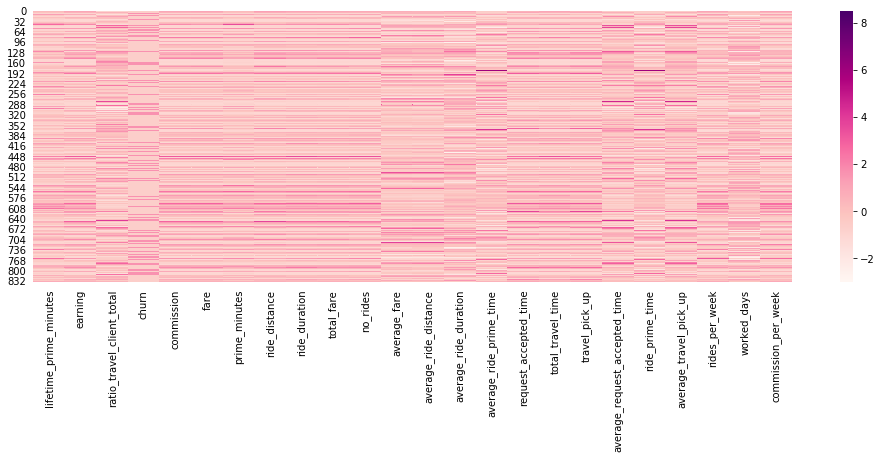

In [59]:
heat = driver_id[["lifetime_prime_minutes","earning","ratio_travel_client_total","churn",'commission', 'fare','prime_minutes', 'ride_distance', 'ride_duration', 'total_fare', 'no_rides', 'average_fare', 'average_ride_distance','average_ride_duration', 'average_ride_prime_time','request_accepted_time','total_travel_time', 'travel_pick_up', 'average_request_accepted_time','ride_prime_time', 'average_travel_pick_up', 'rides_per_week','worked_days', 'commission_per_week']]

scale=sklearn.preprocessing.scale(heat)

scale_df = pd.DataFrame(scale, columns = heat.columns)

plt.figure(figsize=(17,5))
ax = sns.heatmap(scale_df,cmap="RdPu")
plt.tick_params(axis='x',bottom=False)
plt.tick_params(axis='y',left=False)
plt.show()

The heat map above shows us the clusters.
The cluster "commission, fare, prime_minutes, ride_distance, ride_duration, total_fare, no_rides" can be seen as a Life Time Value of a driver. It is as seen from visualisation previously, these variables are highly correlated, as the heat map shows. The cluster of total Life Time Value is contracsted to the cluster "average_fare and average_ride_distance."
Surprisingly there is a contrast between very low values of the variable churn and the cluster. Churned drivers a little total value but a high average value. Seems that drivers who churn tend to make low overall return but high average return for Lyft.

In [60]:
anal = driver_id[['churn','commission', 'fare','prime_minutes', 'ride_distance', 'ride_duration', 'total_fare', 'no_rides', 'average_fare', 'average_ride_distance','average_ride_duration', 'average_ride_prime_time','request_accepted_time','total_travel_time', 'travel_pick_up', 'average_request_accepted_time','ride_prime_time', 'average_travel_pick_up', 'rides_per_week','worked_days', 'commission_per_week']]


We will also try to visualize data with the PCA and the corelation circle

In [61]:
pca = PCA(n_components=2)
pca.fit(anal)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [62]:
pca.explained_variance_ratio_

array([0.99328682, 0.00670887])

In [63]:
print(pca.explained_variance_)

[4.20667982e+10 2.84128242e+08]


In [64]:
pca = PCA(n_components='mle')

In [65]:
def circleOfCorrelations(pc_infos, ebouli):
    plt.figure(figsize=(10,10))
    plt.Circle((0,0),radius=10, color='#352384', fill=False)
    circle1=plt.Circle((0,0),radius=1, color='#352384', fill=False)
    fig = plt.gcf()
    fig.gca().add_artist(circle1)
    for idx in range(len(pc_infos["PC-0"])):
        x = pc_infos["PC-0"][idx]
        y = pc_infos["PC-1"][idx]
        plt.plot([0.0,x],[0.0,y],color="#352384")
        plt.plot(x, y, color='#ff00bf',marker='o')
        plt.annotate(pc_infos.index[idx], xy=(x,y))
    plt.xlabel("PC-0 (%s%%)" % str(ebouli[0])[:4].lstrip("0."), size = 15)
    plt.ylabel("PC-1 (%s%%)" % str(ebouli[1])[:4].lstrip("0."), size = 15)
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.title("Circle of Correlations")

                                       PC-0          PC-1
churn                         -1.084524e-06 -2.731219e-07
commission                     2.981619e-03 -2.931424e-03
fare                           1.018561e-02 -5.323222e-03
prime_minutes                  2.244563e-03 -9.483792e-03
ride_distance                  3.695017e-03  1.836091e-03
ride_duration                  1.241638e-02 -1.571363e-02
total_fare                     1.192648e-02 -1.172570e-02
no_rides                       8.535555e-04 -1.062095e-03
average_fare                  -2.485513e-07  2.511736e-05
average_ride_distance         -3.864545e-07  2.202267e-05
average_ride_duration          9.104183e-07 -1.119343e-06
average_ride_prime_time        6.005816e-06 -1.226673e-04
request_accepted_time          2.046532e-01  6.767402e-01
total_travel_time              9.569773e-01 -2.890148e-01
travel_pick_up                 2.046532e-01  6.767402e-01
average_request_accepted_time -1.281258e-06  5.096892e-05
ride_prime_tim

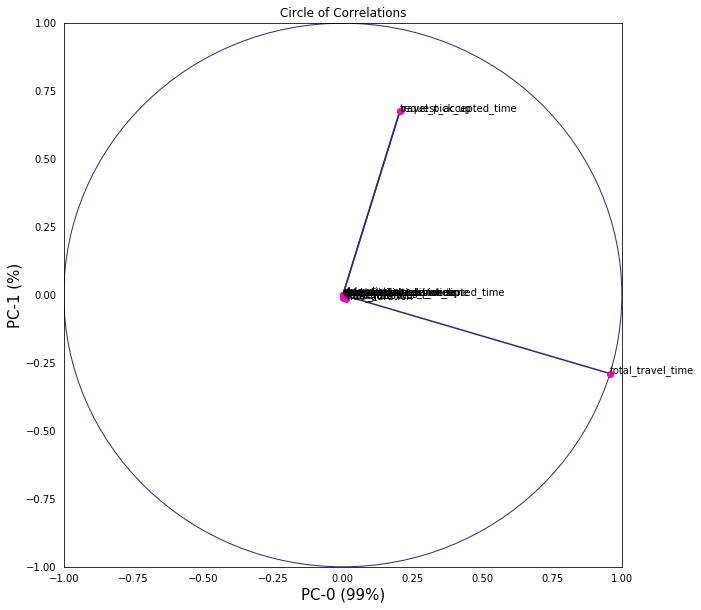

In [66]:
df_norm = anal
pca = PCA(n_components=2)
pca_res = pca.fit_transform(df_norm.values)
# Ebouli
ebouli = pd.Series(pca.explained_variance_ratio_)
#ebouli.plot(kind='bar', title="Principal Components Explained Variance")
#plt.show()
coef = np.transpose(pca.components_)
cols = ['PC-'+str(x) for x in range(len(ebouli))]
pc_infos = pd.DataFrame(coef, columns=cols, index=df_norm.columns)
print(pc_infos)
circleOfCorrelations(pc_infos, ebouli)
plt.tick_params(axis='x',bottom=False)
plt.tick_params(axis='y',left=False)
plt.show()

Since the 2n PC explains less than 1% of variance, we will look only at the 1st PC. The result is similar to what we saw in the heat map, but it shows that it's not as strong. Even though there is a negative correlation between churn and variables in LT cluster, the coefficient shows just a small number. Also the correlation between average distance and duration and churn is also showned by PCA to be negligible, since the coefficients are found very close to 0.

# Predicting the Churn with Logistic Regression and Random Forrest

## Logit

We will use both Lasso and Ridge Regularization and compre the results

In [67]:
analytics = driver_id[['churn','commission', 'fare',
       'prime_minutes', 'ride_distance', 'ride_duration', 'total_fare', 
        'no_rides', 'average_fare', 'average_ride_distance',
       'average_ride_duration', 'average_ride_prime_time',
       'average_total_fare', 'request_accepted_time',
       'total_travel_time', 'travel_pick_up', 'average_request_accepted_time',
       'ride_prime_time', 'average_travel_pick_up', 'worked_days',
       'rides_per_week', 'commission_per_week', 'ratio_travel_client_total',
       'earning', 'lifetime_prime_minutes']]

In [68]:
X = analytics[['commission', 'fare',
       'prime_minutes', 'ride_distance', 'ride_duration', 'total_fare', 
        'no_rides', 'average_fare', 'average_ride_distance',
       'average_ride_duration', 'average_ride_prime_time',
       'average_total_fare', 'request_accepted_time',
       'total_travel_time', 'travel_pick_up', 'average_request_accepted_time',
       'ride_prime_time', 'average_travel_pick_up', 'worked_days',
       'rides_per_week', 'commission_per_week', 'ratio_travel_client_total',
       'earning', 'lifetime_prime_minutes']].as_matrix()
X_features = analytics[['commission', 'fare',
       'prime_minutes', 'ride_distance', 'ride_duration', 'total_fare', 
        'no_rides', 'average_fare', 'average_ride_distance',
       'average_ride_duration', 'average_ride_prime_time',
       'average_total_fare', 'request_accepted_time',
       'total_travel_time', 'travel_pick_up', 'average_request_accepted_time',
       'ride_prime_time', 'average_travel_pick_up', 'worked_days',
       'rides_per_week', 'commission_per_week', 'ratio_travel_client_total',
       'earning', 'lifetime_prime_minutes']].columns

y = driver_id['churn'].values

In [69]:
scaler = StandardScaler()

X = scaler.fit_transform(X)


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=42)
logregL1 = LogisticRegression(C=1,penalty="l1").fit(X_train,y_train)


/Users/hoang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [71]:
logregL1.score(X_train,y_train)

0.9202551834130781

In [72]:
pred_log=logregL1.predict(X_test)

In [73]:
(pred_log==y_test).sum()/len(pred_log==y_test)

0.8952380952380953

In [74]:
pd.DataFrame(data = confusion_matrix(y_test,pred_log), columns = ["Predicted Negative","Predicted Positive"], index=["Negative Class","Positive Class"])

,Predicted Negative,Predicted Positive
Negative Class,144,11
Positive Class,11,44


In [75]:
logregL2 = LogisticRegression(C=0.1,penalty="l2").fit(X_train,y_train)


/Users/hoang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [76]:
logregL2.score(X_train,y_train)

0.9202551834130781

In [77]:
pred_log2=logregL2.predict(X_test)

In [78]:
(pred_log2==y_test).sum()/len(pred_log==y_test)

0.8952380952380953

In [79]:
pd.DataFrame(data = confusion_matrix(y_test,pred_log2), columns = ["Predicted Negative","Predicted Positive"], index=["Negative Class","Positive Class"])

,Predicted Negative,Predicted Positive
Negative Class,143,12
Positive Class,10,45


Both L1 and L2 yield very similar results. For L2, increasing a constraint, yields a smaller accuracy but higher recall. Higher recall rate means that there is a higher prediction rate for actually churned drivers.

For both models we can graph a importance of Features

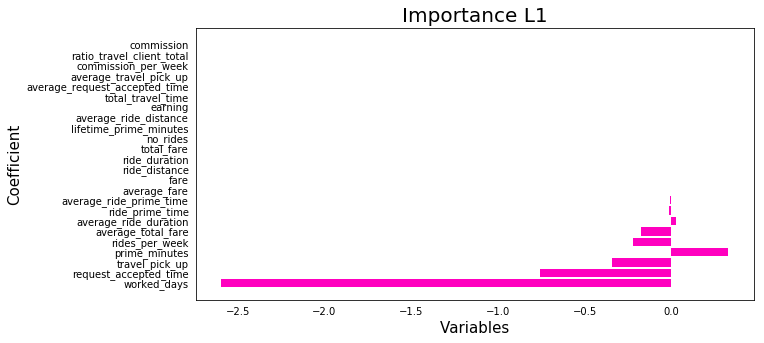

In [80]:
feature = driver_id[['commission', 'fare',
       'prime_minutes', 'ride_distance', 'ride_duration', 'total_fare', 
        'no_rides', 'average_fare', 'average_ride_distance',
       'average_ride_duration', 'average_ride_prime_time',
       'average_total_fare', 'request_accepted_time',
       'total_travel_time', 'travel_pick_up', 'average_request_accepted_time',
       'ride_prime_time', 'average_travel_pick_up', 'worked_days',
       'rides_per_week', 'commission_per_week', 'ratio_travel_client_total',
       'earning', 'lifetime_prime_minutes']]

feat_importance = logregL1.coef_

index = np.argsort(np.absolute(feat_importance))

plt.figure(figsize = (10, 5))
plt.title("Importance L1", fontsize = 20)
plt.barh(range(X.shape[1]), feat_importance[0][index][0][::-1], align="center",color = "#ff00bf")
plt.xlabel('Variables', size = 15)
plt.ylabel('Coefficient', size = 15)
plt.yticks(range(feature.shape[1]), feature.columns[index][0][::-1])
plt.tick_params(axis='x',bottom=False)
plt.tick_params(axis='y',left=False)
plt.show()

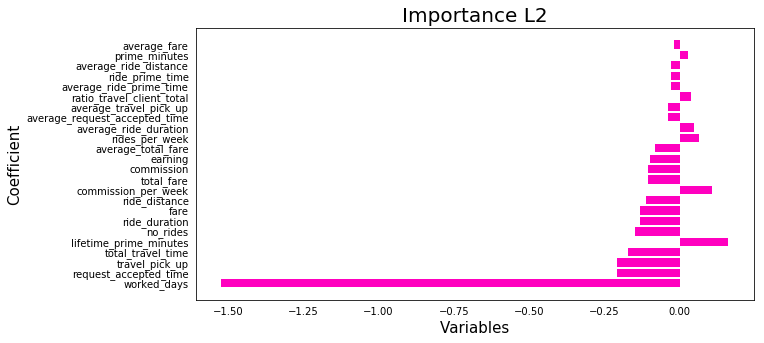

In [81]:
feature = driver_id[['commission', 'fare',
       'prime_minutes', 'ride_distance', 'ride_duration', 'total_fare', 
        'no_rides', 'average_fare', 'average_ride_distance',
       'average_ride_duration', 'average_ride_prime_time',
       'average_total_fare', 'request_accepted_time',
       'total_travel_time', 'travel_pick_up', 'average_request_accepted_time',
       'ride_prime_time', 'average_travel_pick_up', 'worked_days',
       'rides_per_week', 'commission_per_week', 'ratio_travel_client_total',
       'earning', 'lifetime_prime_minutes']]

feat_importance = logregL2.coef_

index = np.argsort(np.absolute(feat_importance))

plt.figure(figsize = (10, 5))
plt.title("Importance L2", fontsize = 20)
plt.barh(range(X.shape[1]), feat_importance[0][index][0][::-1], align="center",color = "#ff00bf")
plt.xlabel('Variables', size = 15)
plt.ylabel('Coefficient', size = 15)
plt.yticks(range(feature.shape[1]), feature.columns[index][0][::-1])
plt.tick_params(axis='x',bottom=False)
plt.tick_params(axis='y',left=False)
plt.show()

After choosing variables, use logit to predict churned drivers

In [82]:
cross_val_score(logregL2, X, y, scoring = "accuracy", cv = 10).mean()

/Users/hoang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hoang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hoang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hoang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hoang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

0.9103700516351119

In [83]:
cross_val_score(logregL2, X, y, scoring = "recall", cv = 5).mean()

/Users/hoang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hoang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hoang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hoang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hoang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

0.8272727272727274

In [84]:
feat_importance

array([[-0.10364304, -0.13065022,  0.02729959, -0.1126874 , -0.13211113,
        -0.10364304, -0.14772502, -0.01808557, -0.02803494,  0.04618171,
        -0.02862538, -0.08206405, -0.20811502, -0.17074802, -0.20811502,
        -0.03950061, -0.02862538, -0.03950061, -1.52247803,  0.06369913,
         0.10789009,  0.03802635, -0.09799478,  0.16158964]])

## Random Forrest



It's going to be interesting to see how random forrest works with the data sets. We assume that regression trees are going to work well, since there data forms clusters.

In [85]:
labels = np.array(graph['churn'])
features= graph.drop('churn', axis = 1)
feature_list = features.columns
features = np.array(features)

In [86]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [87]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (627, 23)
Training Labels Shape: (627,)
Testing Features Shape: (210, 23)
Testing Labels Shape: (210,)


In [88]:
rf = RandomForestClassifier(n_estimators = 10, random_state = 42,max_depth=5)
rf.fit(train_features, train_labels);


In [89]:
predictions = rf.predict(train_features)


In [90]:
rf.score(train_features,train_labels)

0.9553429027113237

In [91]:
predictions = rf.predict(test_features)
errors = predictions== test_labels

In [92]:
sum(errors)/(len(errors))

0.919047619047619

In [93]:
pd.DataFrame(data = confusion_matrix(predictions, test_labels), columns = ["Predicted Negative","Predicted Positive"], index=["Negative Class","Positive Class"])

,Predicted Negative,Predicted Positive
Negative Class,151,14
Positive Class,3,42


max_depth=5 gives us the best perofmrance on test data

23


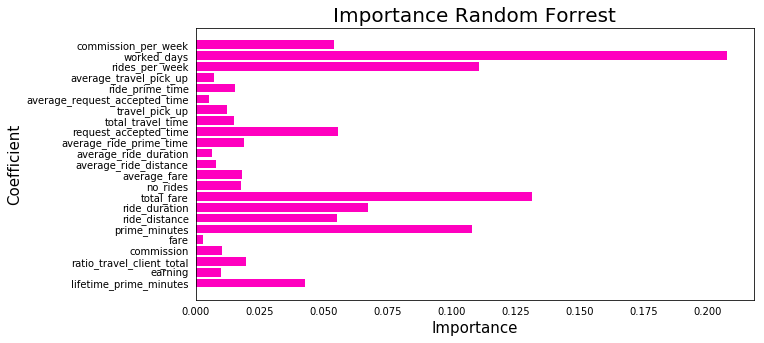

In [94]:
def plot_feature_importances_cancer(model):
    n_features = len(feature_list)
    print(len(feature_list))
    
    plt.figure(figsize = (10, 5))
    plt.title("Importance Random Forrest", fontsize = 20)

    plt.barh(np.arange(n_features), model.feature_importances_, align='center', color="#ff00bf")
    plt.yticks(np.arange(n_features), feature_list)
    plt.xlabel("Importance",size = 15)
    plt.ylabel("Coefficient",size = 15)
    plt.tick_params(axis='x',bottom=False)
    plt.tick_params(axis='y',left=False)
    plt.show()


plot_feature_importances_cancer(rf)

Although the results for L1 and L2 result the different importance, they generate a similar direction of coefficient on the churn rate. Check the importance of features with Random Forest. 

All models gave us a pretty good prediction rate. The best, as expected was Random Forrest. The model also gave us a new interpretation. Request-Accept time might be a further strong predictor for the churn rate and also travel time to pick up the customers.

In [95]:
gbrt = GradientBoostingClassifier(random_state=0,max_depth=1,learning_rate=0.1)

In [96]:
gbrt.fit(train_features,train_labels)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [97]:
predictions = gbrt.predict(train_features)

In [98]:
sum(predictions==train_labels)/len(train_labels)

0.9234449760765551

In [99]:
predictions = gbrt.predict(test_features)

In [100]:
sum(predictions==test_labels)/len(test_labels)

0.9142857142857143

In [101]:
pd.DataFrame(data = confusion_matrix(predictions, test_labels), columns = ["Predicted Negative","Predicted Positive"], index=["Negative Class","Positive Class"])

,Predicted Negative,Predicted Positive
Negative Class,149,13
Positive Class,5,43


23


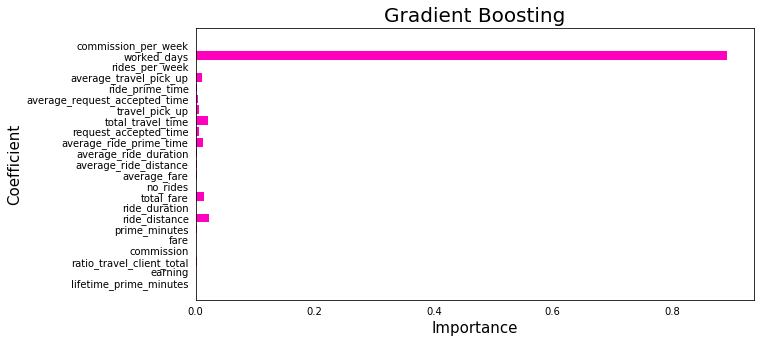

In [102]:
def plot_feature_importances_cancer(model):
    n_features = len(feature_list)
    print(len(feature_list))
    
    plt.figure(figsize = (10, 5))
    plt.title("Gradient Boosting", fontsize = 20)

    plt.barh(np.arange(n_features), model.feature_importances_, align='center', color="#ff00bf")
    plt.yticks(np.arange(n_features), feature_list)
    plt.xlabel("Importance",size = 15)
    plt.ylabel("Coefficient",size = 15)
    plt.tick_params(axis='x',bottom=False)
    plt.tick_params(axis='y',left=False)
    plt.show()


plot_feature_importances_cancer(gbrt)